<a href="https://colab.research.google.com/github/zendegani/Detection_of_Surface_Cracks_using_Deep_Learning/blob/main/IBM-AI-Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">

<ul>
    <li><a href="#download_data"> Download data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#trasform_Data_object">Transform Object and Dataset Object</a></li>
</ul>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


In this section, you are going to download the data from IBM object storage using <b>wget</b>, then unzip them.  <b>wget</b> is a command the retrieves content from web servers, in this case its a zip file. Locally we store the data in the directory  <b>/resources/data</b> . The <b>-p</b> creates the entire directory tree up to the given directory.


First, we download the file that contains the images, if you dint do this in your first lab uncomment:


In [37]:
!ls sample_data

anscombe.json				      mnist_train_small.csv
california_housing_test.csv		      Negative
california_housing_train.csv		      Positive
concrete_crack_images_for_classification.zip  README.md
mnist_test.csv


In [13]:
root_zip='/content/sample_data'

In [15]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P $root_zip

--2020-11-16 09:03:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘/content/sample_data/concrete_crack_images_for_classification.zip’

concrete_crack_imag 100%[===================>] 233.90M  16.7MB/s    in 15s     

2020-11-16 09:03:38 (15.6 MB/s) - ‘/content/sample_data/concrete_crack_images_for_classification.zip’ saved [245259777/245259777]



We then unzip the file, this ma take a while:


In [16]:
# !unzip -q  $root_zip/concrete_crack_images_for_classification.zip -d  $root_zip

We then download the files that contain the negative images:


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab:


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim 
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [6]:
import torchvision.models as models

In [7]:
import time

<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  If the parameter <code>train</code> is set to <code>True</code>, use the first 30 000  samples as training data; otherwise, the remaining samples will be used as validation data. Do not forget to sort your files so they are in the same order.  


In [8]:
# root = "/content/sample_data"
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory= root_zip
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>


Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.


In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

composed =transforms.Compose([ transforms.Resize(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])


Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:


In [14]:
train_dataset=Dataset(transform=composed,train=True)
validation_dataset=Dataset(transform=composed,train=False)

We  can find the shape of the image:


In [15]:
validation_dataset[0][0].shape

torch.Size([3, 224, 224])

We see that it's a color image with three channels:


In [16]:
size_of_image=3*227*227
size_of_image

154587

In [17]:
torch.manual_seed(0)

<b>Custom Module:</b>


In [18]:
# Define the learning rate, optimizer, criterion and data loader
learning_rate = 0.001
momentum=0.1

In [19]:
input_size = 3 * 227 * 227
output_size = 2

<b>Model Object:</b>


In [20]:
model = models.resnet18(pretrained=True)

In [21]:
for param in model.parameters():
    param.requires_grad = False

In [22]:
model.fc = nn.Linear(512,2)

In [23]:
# Convert model to be used on GPU
model = model.to(device)

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Optimizer:</b>


In [25]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], 
                             lr=learning_rate )

<b>Criterion:</b>


In [26]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>


In [28]:
batch_size_train = 100
batch_size_val = batch_size_train
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size_val)

<b>Train Model with 20 epochs: </b>


In [ ]:
n_epochs = 20
loss_list = []
loss_list_epoch = []
accuracy = []
accuracy_list = []
correct = 0
N_train = len(train_dataset)
N_test = len(validation_dataset)

print("Number of items in training set : ", N_train)
print("Number of items in testing set : ", N_test)

# def train_model(n_epochs):
start_time = time.time()
for epoch in range(n_epochs):
    start_time_epoch = time.time()
    loss_sublist = []
    for i, (x, y) in enumerate(train_loader):        
        print('-' * 30)
        print('Epoch {:d} -  Iteration (train phase) {}/{}'.format(epoch+1, i+1, int(N_train/batch_size_train)))
        i_start_time = time.time() 
        
        x = x.to(device)
        y = y.to(device)

        model.train()
        optimizer.zero_grad()
        z = model(x) 

        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss_list_epoch.append(loss.data.item())
        loss.backward()

        optimizer.step()
        
        print("Finished in {} (s)".format(time.time()-i_start_time))
    loss_list.append(np.mean(loss_sublist))

    correct = 0
    # perform a prediction on the validationdata
    for i, (x_test, y_test) in enumerate(validation_loader):
        print('+' * 30)
        print('Epoch {:d} -  Iteration (validation phase) {}/{}'.format(epoch+1, i+1, int(N_test/batch_size_val)))
        i_start_time = time.time()

        x_test, y_test = x_test.to(device), y_test.to(device)

        model.eval()
        z = model(x_test) 
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()       
        print("Finished in {} (s)".format(time.time()-i_start_time))

    accuracy = correct / N_test    
    print("Epoch %d - accuracy: %.3f" % (epoch+1, accuracy))
    print("-" * 72)
    accuracy_list.append(accuracy)   
        
        # Save model
        model_file_path = os.path.join(root_zip , "resnet18_trained_model_epoch_{}.pth".format(epoch+1))
        torch.save(model.state_dict(), model_file_path)

        # Duration for epoch
        print("Finished epoch {} in {} (s).".format(epoch+1, time.time()-start_time_epoch))

# Duration for the whole model training
print("Finished training in {} (s).".format(time.time()-start_time))

# train_model(n_epochs)

Streaming output truncated to the last 5000 lines.
Epoch 16 -  Iteration (validation phase) 39/100
Finished in 0.10111212730407715 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validation phase) 40/100
Finished in 0.10043811798095703 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validation phase) 41/100
Finished in 0.1011660099029541 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validation phase) 42/100
Finished in 0.10016727447509766 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validation phase) 43/100
Finished in 0.10103130340576172 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validation phase) 44/100
Finished in 0.10050296783447266 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validation phase) 45/100
Finished in 0.10042548179626465 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validation phase) 46/100
Finished in 0.10112667083740234 (s)
++++++++++++++++++++++++++++++
Epoch 16 -  Iteration (validat

In [ ]:
accuracy_list

[0.9919,
 0.9933,
 0.9938,
 0.9937,
 0.9937,
 0.9938,
 0.9937,
 0.9935,
 0.9934,
 0.9927,
 0.9924,
 0.9918,
 0.9939,
 0.9926,
 0.9931,
 0.9932,
 0.9925,
 0.993,
 0.9939,
 0.9924]

In [31]:
plt.plot(loss_list_epoch[::50],'o-')
plt.ylabel('Loss');plt.xlabel('Epoch')

In [ ]:
count = 0
list_mis = []
for idx, (x, y) in enumerate(torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)):
    x = x.to(device)
    y = y.to(device)
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        list_mis.append([idx,yhat,y])
        print('sample {:} predicted value: {:} actual value:{:}'.format(idx,yhat,y))
        count += 1
    if count >= 10:
        break  

yhat:  tensor([1], device='cuda:0')
yhat:  tensor([0], device='cuda:0')
yhat:  tensor([1], device='cuda:0')
yhat:  tensor([0], device='cuda:0')
yhat:  tensor([1], device='cuda:0')
[[17, tensor([1], device='cuda:0')], [62, tensor([0], device='cuda:0')], [277, tensor([1], device='cuda:0')], [452, tensor([0], device='cuda:0')], [639, tensor([1], device='cuda:0')]]


In [30]:
# for idx , yhat, _ in list_mis:
#   print('sample {:} predicted value: {:} actual value:{:}'.format(idx,yhat,dataset_val[idx][1].item()))

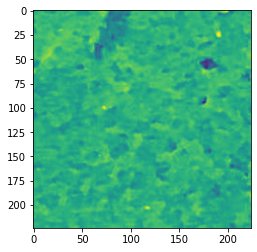

In [ ]:
plt.imshow(dataset_val[list_mis[0]][0][0,:,:])

Copyright © 2019 <a href="cognitiveclass.ai"> cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>
